In [408]:
from __future__ import print_function, unicode_literals, absolute_import, division
import sys
import numpy as np
import matplotlib
matplotlib.rcParams["image.interpolation"] = None
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

from glob import glob
from tifffile import imread, imsave
from csbdeep.utils import Path, normalize
from csbdeep.io import save_tiff_imagej_compatible

from stardist import random_label_cmap, _draw_polygons, export_imagej_rois
from stardist.models import StarDist2D

np.random.seed(6)
lbl_cmap = random_label_cmap()
from ipywidgets import interactive, interact
import os
import pandas as pd
from skimage.measure import regionprops_table
import seaborn as sns
from tqdm.notebook import tqdm
from skimage.transform import resize
import tensorflow as tf
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.compat.v1.Session(config=config)
from joblib import delayed, Parallel
from scipy.signal import find_peaks
from scipy.ndimage import gaussian_filter
from natsort import natsorted
from skimage.segmentation import clear_border, find_boundaries
from skimage.morphology import opening, erosion

In [540]:
model_dir = "/home/georgeos/Storage/Dropbox (Cambridge University)/Phase/models/bent_noisematched_allsize_empty_und6_unarelu_unlasigmoid_epc2000_exp_nohist_biggrid"
model = StarDist2D(None, name='stardist_no_shape_completion', basedir=model_dir)

Loading network weights from 'weights_best.h5'.
Couldn't load thresholds from 'thresholds.json', using default values. (Call 'optimize_thresholds' to change that.)
Using default values: prob_thresh=0.5, nms_thresh=0.4.


In [5]:
data = imread("/home/georgeos/Storage/Dropbox (Cambridge University)/Phase/real_data/Lane_02_pos_006_trench_x_0423_y_0055_w_0046_h_0460_c_Phase.tif")[:,:256,:]

In [6]:
X = []
for x in range(len(data)):
    X.append(data[x])

In [7]:
320/4

80.0

In [528]:
#X = sorted(glob("/home/georgeos/Storage/Dropbox (Cambridge University)/PhD_Georgeos_Hardo/ML_based_segmentation_results/40x_Ph2_test_1.5/extracted_long_trenches/*.tif"))
#X = list(map(imread,X))

requires_resize = True
resize_shape = (320,64) # (320,64) (512,128)
if requires_resize:
    #X = [resize(x,(80,16), order=1, mode='reflect', cval=0, clip=True, preserve_range=True, anti_aliasing=None, anti_aliasing_sigma=None) for x in tqdm(X)]
    X = [resize(x,resize_shape, order=1, mode='reflect', cval=0, clip=True, preserve_range=True, anti_aliasing=None, anti_aliasing_sigma=None) for x in tqdm(X)]

n_channel = 1 if X[0].ndim == 2 else X[0].shape[-1]
axis_norm = (0,1)   # normalize channels independently
# axis_norm = (0,1,2) # normalize channels jointly
if n_channel > 1:
    print("Normalizing image channels %s." % ('jointly' if axis_norm is None or 2 in axis_norm else 'independently'))



  0%|          | 0/4368 [00:00<?, ?it/s]

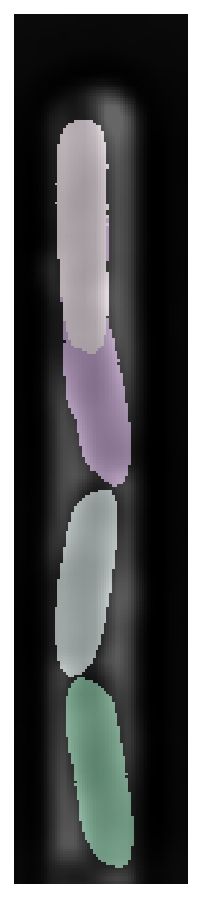

In [542]:
img = normalize(X[181], 1,99.8, axis=axis_norm)
labels, details = model.predict_instances(img, prob_thresh=0.7,nms_thresh=0.7)
plt.figure(figsize=(8,8))
plt.imshow(img if img.ndim==2 else img[...,0], clim=(0,1), cmap='gray')
plt.imshow(labels, cmap=lbl_cmap, alpha=0.6)
plt.axis('off');

In [543]:
all_labels = []
all_labels_nms = []
all_imgs = []
cell_data = pd.DataFrame()
properties = ["area","centroid","major_axis_length","minor_axis_length","label"]
for x in tqdm(range(len(X))):
    img = normalize(X[x], 1,99.8, axis=axis_norm)
    labels, details = model.predict_instances(img, prob_thresh=0.5,nms_thresh=0.1)
    nms_labels, details = model.predict_instances(img, prob_thresh=0.7,nms_thresh=0.7)
    border_cleared = clear_border(labels,buffer_size=5).astype(bool)*labels
    border_cleared_nms = clear_border(nms_labels,buffer_size=5).astype(bool)*nms_labels
    all_labels.append(border_cleared)
    all_labels_nms.append(border_cleared_nms)
    all_imgs.append(img)
    
    cell_data = cell_data.append(pd.DataFrame(regionprops_table(border_cleared,properties = properties)).sort_values(by = "centroid-0").iloc[0])
cell_data.reset_index(inplace=True)

  0%|          | 0/4368 [00:00<?, ?it/s]

IndexError: single positional indexer is out-of-bounds

In [544]:
def get_true_mother(x):
    all_labels_converted = (all_labels[x].astype(bool) * all_labels_nms[x].astype(bool))*all_labels_nms[x]
    for lab in np.unique(all_labels_converted):
        if np.sum(all_labels_converted == lab) < 15:
            all_labels_converted = np.where(all_labels_converted != lab, all_labels_converted, 0)
    mother_cell_data = pd.DataFrame(regionprops_table(all_labels_converted,properties = properties)).sort_values(by = "centroid-0").iloc[0]
    mother_cell_mask = all_labels_converted == mother_cell_data["label"]
    mother_cell_border = find_boundaries(mother_cell_mask,mode="outer")
    nms_mask_labels = np.unique(mother_cell_border*(all_labels_nms[x]))
    nms_mask_labels = np.setdiff1d(nms_mask_labels,np.unique(all_labels_converted))
    nms_mask_labels = nms_mask_labels[nms_mask_labels > 0]
    border_nms = (find_boundaries(mother_cell_mask,mode="outer")*all_labels_nms[x])
    entire_mother = np.zeros(mother_cell_mask.shape)
    entire_mother += mother_cell_mask
    for lab in nms_mask_labels:
        if np.sum(border_nms == lab) > 30: 
            entire_mother += (all_labels_nms[x] == lab)
    return entire_mother

In [503]:
get_true_mother(0)

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [545]:
mothers = []
mother_data = pd.DataFrame()
for x in range(len(all_labels_nms)):
    true_mother = get_true_mother(x).astype(int)
    mothers.append(true_mother)
    mother_data = mother_data.append(pd.DataFrame(regionprops_table(true_mother,properties = properties)))

IndexError: single positional indexer is out-of-bounds

In [549]:
mother_data.reset_index(inplace=True)

Text(0.5, 0, 'Frame')

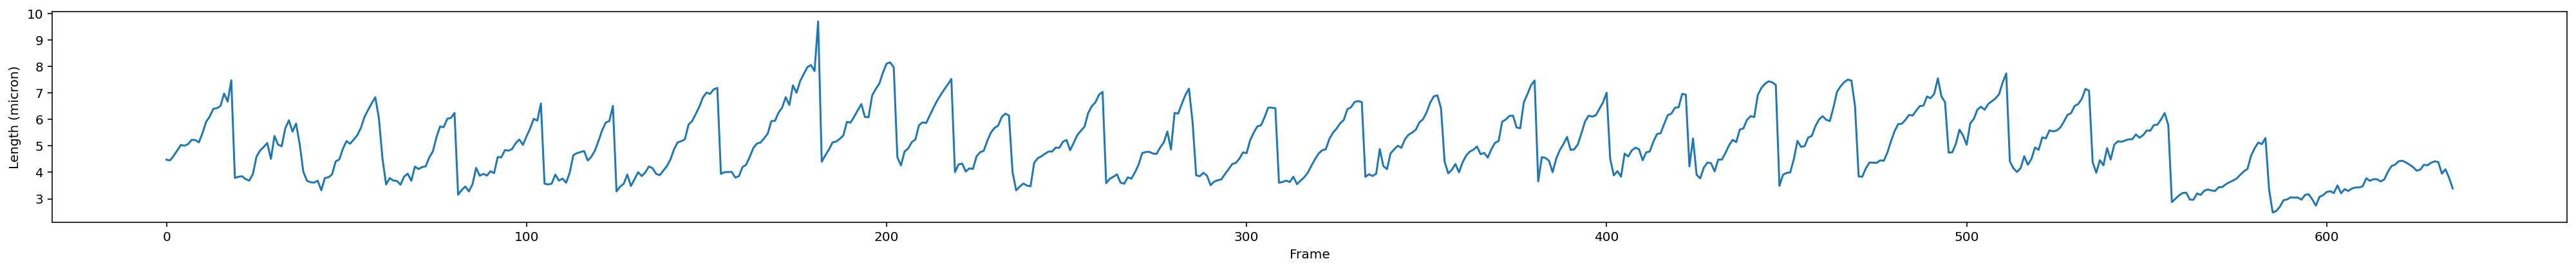

In [550]:
plt.figure(figsize=(35,3))
plt.plot(mother_data["major_axis_length"]*0.065)
plt.ylabel("Length (micron)")
plt.xlabel("Frame")
##5% val

Text(0.5, 0, 'Frame')

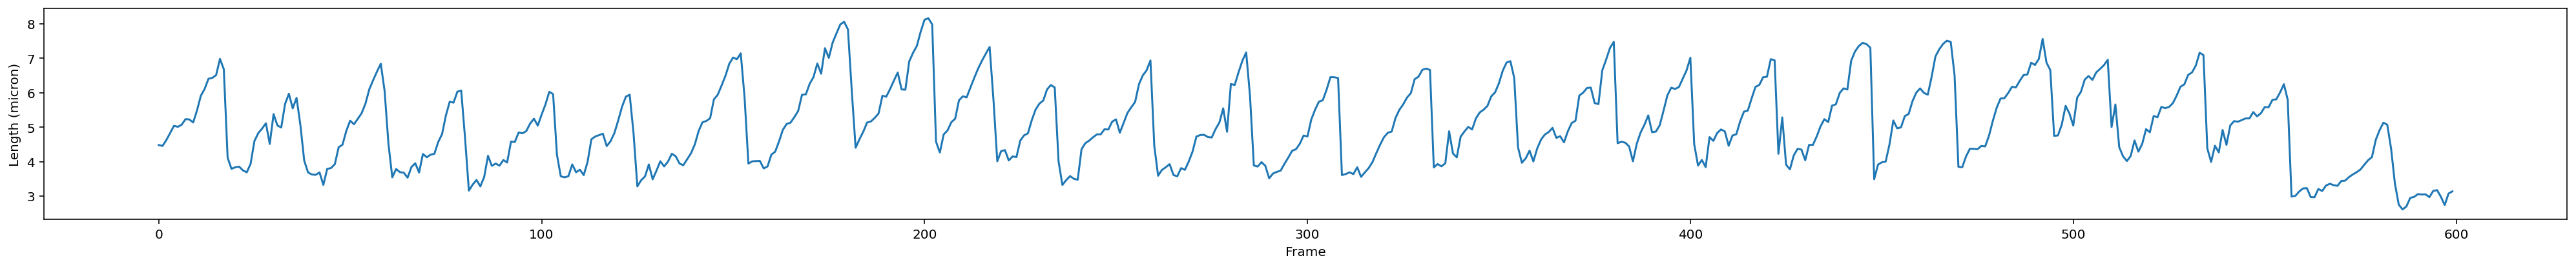

In [547]:
plt.figure(figsize=(35,3))
plt.plot(cell_data.reset_index()["major_axis_length"][:600]*0.065)
plt.ylabel("Length (micron)")
plt.xlabel("Frame")
##5% val

In [538]:
@interact(x=(0,len(mothers)-1))
def f(x):
    plt.imshow(mothers[x])
    plt.show()
    plt.close()

interactive(children=(IntSlider(value=307, description='x', max=614), Output()), _dom_classes=('widget-interac…

  0%|          | 0/2411 [00:00<?, ?it/s]

KeyboardInterrupt: 

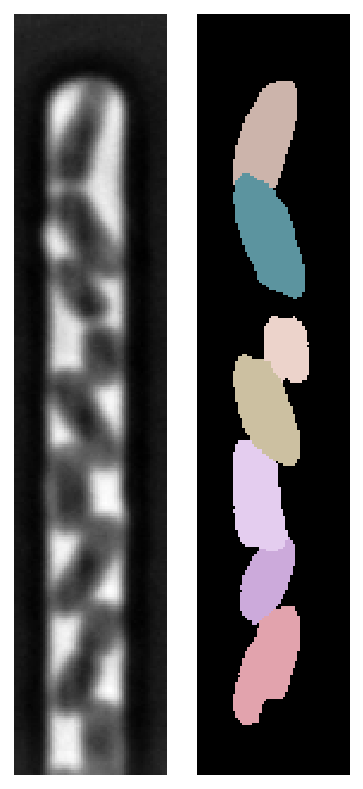

In [182]:
for x in tqdm(range(len(all_labels))):
    f, ax = plt.subplots(1,2,figsize=(3,7))
    ax[0].imshow(all_imgs[x],cmap="Greys_r")
    ax[1].imshow(all_labels[x],cmap=lbl_cmap)
    ax[1].axis("off")
    ax[0].axis("off")
    plt.savefig(model_dir+"/diagnostics/{}.jpeg".format(str(x).zfill(4)))
    plt.tight_layout()
    plt.close()

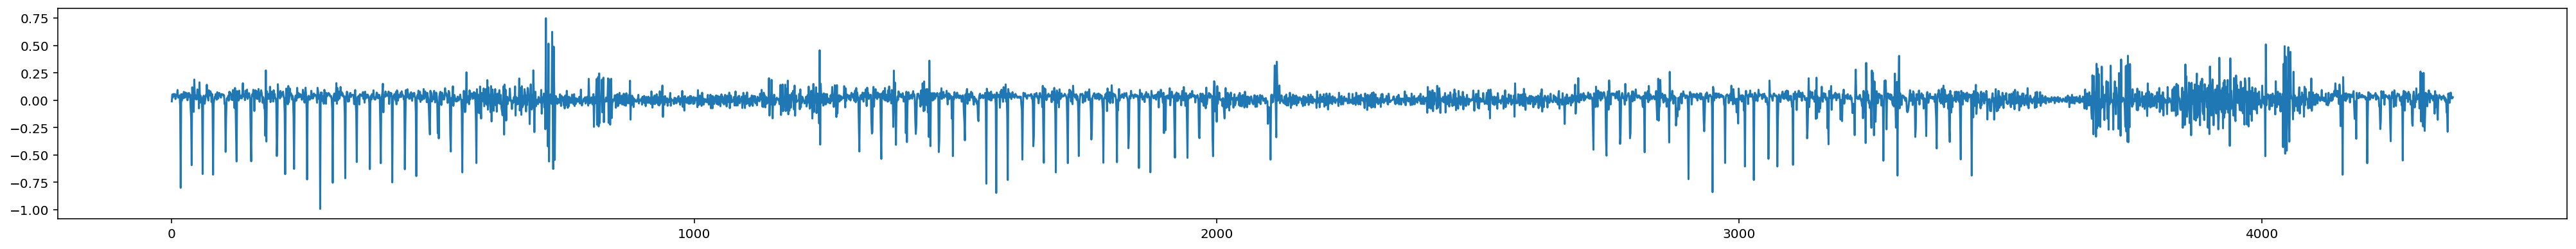

In [247]:
growth_data = np.array(cell_data.reset_index()["major_axis_length"])
fig,ax = plt.subplots(figsize=(35,3))
ax.plot(np.diff(np.log2(growth_data)))

In [250]:
growth_rates = np.diff(np.log2(growth_data))

In [254]:
def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w

In [1]:
fig,ax = plt.subplots(figsize=(35,3))
plt.plot(moving_average(np.where((growth_rates > 0) & (growth_rates < 0.1), growth_rates, 0),5))

NameError: name 'plt' is not defined

Text(0, 0.5, 'Length (micron)')

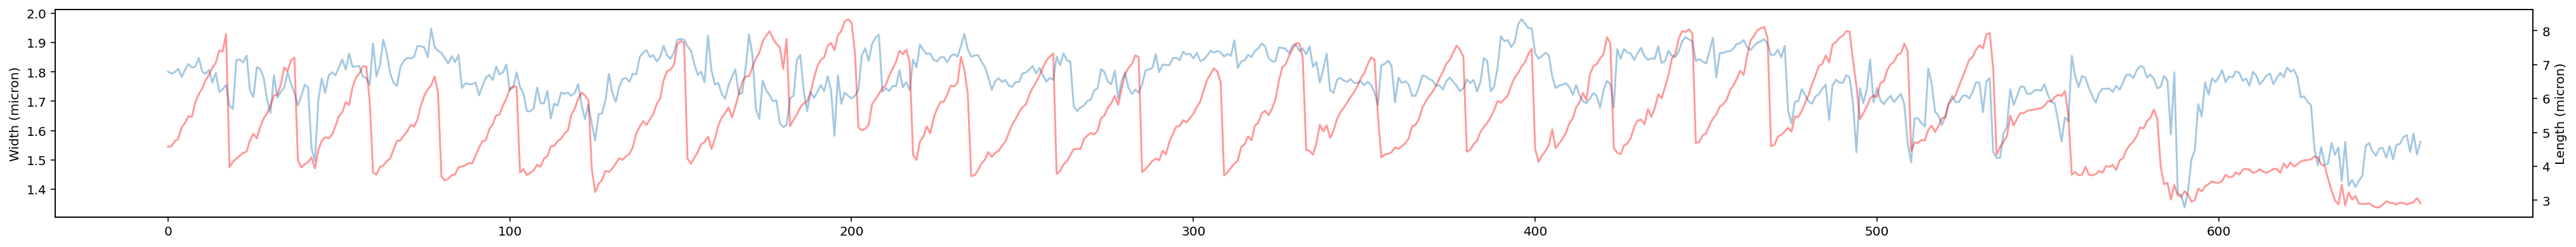

In [101]:
fig,ax = plt.subplots(figsize=(35,3))
ax.plot(cell_data.reset_index()["minor_axis_length"][:]*0.065,alpha=0.4)
ax2=ax.twinx()
ax2.plot(cell_data.reset_index()["major_axis_length"]*0.065,c="r",alpha=0.4)
ax.set_ylabel("Width (micron)")
ax2.set_ylabel("Length (micron)")
#plt.savefig("/home/georgeos/testtwin3.pdf")

Text(0.5, 0, 'Frame')

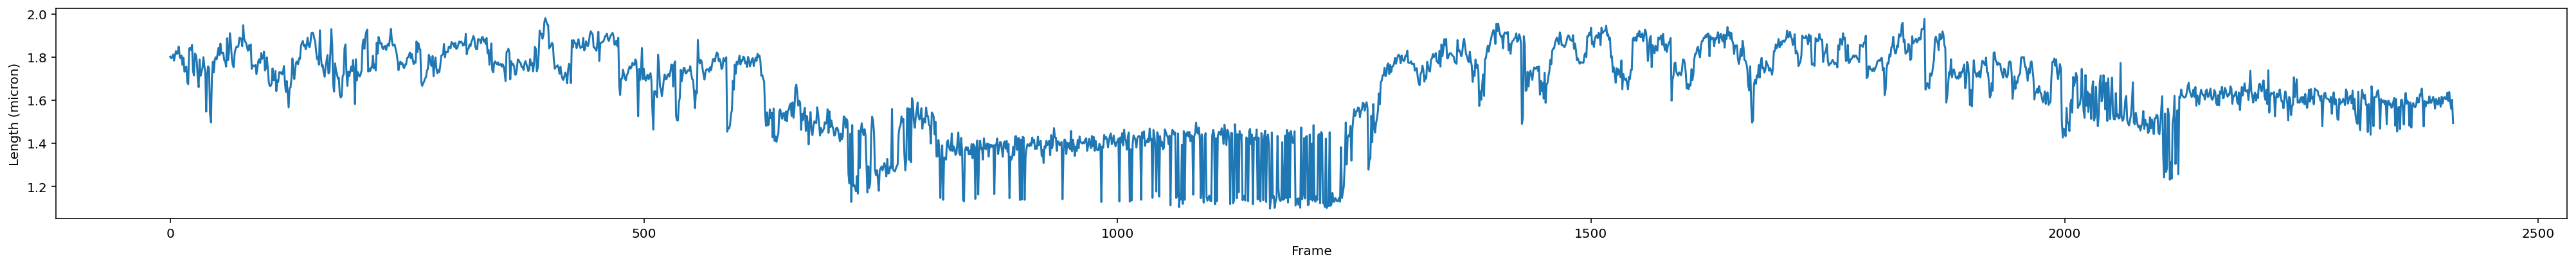

In [153]:
plt.figure(figsize=(35,3))
plt.plot(cell_data.reset_index()["minor_axis_length"][:]*0.065)
plt.ylabel("Length (micron)")
plt.xlabel("Frame")
##5% val

Text(0.5, 0, 'Frame')

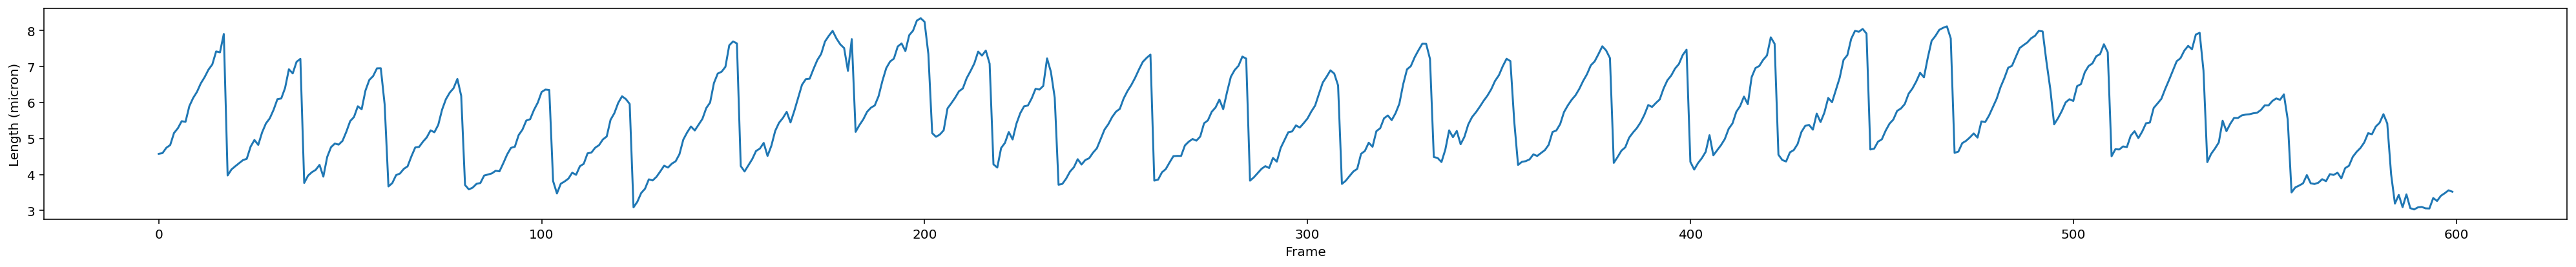

In [155]:
plt.figure(figsize=(35,3))
plt.plot(cell_data.reset_index()["major_axis_length"][:600]*0.065)
plt.ylabel("Length (micron)")
plt.xlabel("Frame")
##5% val

In [ ]:
plt.figure(figsize=(35,5))
plt.plot(cell_data.reset_index()["major_axis_length"].iloc[900:1100])
plt.ylabel("Length (micron)")
plt.xlabel("Frame")

In [ ]:
plt.figure(figsize=(20,1))
plt.plot(cell_data.reset_index()["minor_axis_length"])

In [ ]:
output_dir = "/home/georgeos/Storage/Dropbox (Cambridge University)/PhD_Georgeos_Hardo/ML_based_segmentation_results/40x_Ph2_test_1.5/predictions_0.2"
try:
    os.mkdir(output_dir)
except:
    pass
try:
    os.mkdir(output_dir+"/masks_resized/")
    os.mkdir(output_dir+"/images_resized/")
except:
    pass
try:
    os.mkdir(output_dir+"/diagnostics/")
except:
    pass
try:
    os.mkdir(output_dir+"/postprocessed/")
except:
    pass

In [ ]:
all_labels = []
all_details = []
for z in tqdm(range(len(X))):
    img = normalize(X[z], 1,100, axis=axis_norm)
    labels, details = model.predict_instances(img, prob_thresh=0.2, nms_thresh=0.01)
    imsave(
        output_dir+"/masks_resized/{}".format(names[z]),labels)
    imsave(
        output_dir+"/images_resized/{}".format(names[z]),img)
    all_labels.append(labels)
    all_details.append(details)

In [ ]:
a = 0
for trench in tqdm(trench_names):
    idxs = trenches_idx[trench]
    for z in (idxs):
        cleared_mask = clear_side_masks(all_labels[z],a)
        imsave(output_dir+"/postprocessed/{}".format(names[z]),cleared_mask)
    a+=1

In [ ]:
pp = sorted(glob("/home/georgeos/Storage/Dropbox (Cambridge University)/PhD_Georgeos_Hardo/ML_based_segmentation_results/40x_Ph2_test_1.5/predictions_0.2/postprocessed/*"))
lbls = sorted(glob("/home/georgeos/Storage/Dropbox (Cambridge University)/PhD_Georgeos_Hardo/ML_based_segmentation_results/40x_Ph2_test_1.5/predictions_0.2/postprocessed/*"))


def plotter(z): 
    labels = all_labels[z]
    details = all_details[z]
    img = X[z]
    probmap = np.zeros(labels.shape)
    for x in range(len(details["points"])):
        probmap[np.where(labels == labels[details["points"][x][0],details["points"][x][1]])] = details["prob"][x]
    f, ax = plt.subplots(1,5,figsize=(7.9,4))
    ax[0].imshow(img,cmap="Greys_r")
    ax[1].imshow(labels,cmap=lbl_cmap)
    prob = ax[3].imshow(probmap,cmap="afmhot",vmin=0,vmax=1)
    ax[2].imshow(img,cmap="Greys_r")
    ax[2].imshow(labels,cmap=lbl_cmap,alpha=0.45)
    ax[2].set_title("PC+Masks")
    f.colorbar(prob,ax=ax[3])
    ax[3].set_title("P(Mask)")
    ax[1].set_title("Masks")
    ax[0].set_title("PC_image")
    ax[4].imshow(imread(pp[z]),cmap=lbl_cmap)
    ax[4].set_title("Post-proc")
    for axs in ax:
        axs.axis("off")
    plt.tight_layout()
    plt.savefig(output_dir+"/diagnostics/{}".format(names[z][:-3]+"jpeg"),dpi=100)
    plt.close()

In [ ]:
Parallel(n_jobs=1)(delayed(plotter)(i) for i in tqdm(range(len(all_labels)))) #plotter is leaking memory, use n_jobs = 1 for now

In [ ]:
output_dir = "/home/georgeos/Storage/Dropbox (Cambridge University)/PhD_Georgeos_Hardo/ML_based_segmentation_results/40x_Ph2_test_1.5/predictions_0.1"
try:
    os.mkdir(output_dir)
except:
    pass
try:
    os.mkdir(output_dir+"/masks_resized/")
    os.mkdir(output_dir+"/images_resized/")
except:
    pass
try:
    os.mkdir(output_dir+"/diagnostics/")
except:
    pass
try:
    os.mkdir(output_dir+"/postprocessed/")
except:
    pass

In [ ]:
all_labels = []
all_details = []
for z in tqdm(range(len(X))):
    img = normalize(X[z], 1,100, axis=axis_norm)
    labels, details = model.predict_instances(img, prob_thresh=0.1, nms_thresh=0.01)
    imsave(
        output_dir+"/masks_resized/{}".format(names[z]),labels)
    imsave(
        output_dir+"/images_resized/{}".format(names[z]),img)
    all_labels.append(labels)
    all_details.append(details)

In [ ]:
a = 0
for trench in tqdm(trench_names):
    idxs = trenches_idx[trench]
    for z in (idxs):
        cleared_mask = clear_side_masks(all_labels[z],a)
        imsave(output_dir+"/postprocessed/{}".format(names[z]),cleared_mask)
    a+=1

In [ ]:
pp = sorted(glob("/home/georgeos/Storage/Dropbox (Cambridge University)/PhD_Georgeos_Hardo/ML_based_segmentation_results/40x_Ph2_test_1.5/predictions_0.1/postprocessed/*"))

def plotter(z): 
    labels = all_labels[z]
    details = all_details[z]
    img = X[z]
    probmap = np.zeros(labels.shape)
    for x in range(len(details["points"])):
        probmap[np.where(labels == labels[details["points"][x][0],details["points"][x][1]])] = details["prob"][x]
    f, ax = plt.subplots(1,5,figsize=(7.9,4))
    ax[0].imshow(img,cmap="Greys_r")
    ax[1].imshow(labels,cmap=lbl_cmap)
    prob = ax[3].imshow(probmap,cmap="afmhot",vmin=0,vmax=1)
    ax[2].imshow(img,cmap="Greys_r")
    ax[2].imshow(labels,cmap=lbl_cmap,alpha=0.45)
    ax[2].set_title("PC+Masks")
    f.colorbar(prob,ax=ax[3])
    ax[3].set_title("P(Mask)")
    ax[1].set_title("Masks")
    ax[0].set_title("PC_image")
    ax[4].imshow(imread(pp[z]),cmap=lbl_cmap)
    ax[4].set_title("Post-proc")
    for axs in ax:
        axs.axis("off")
    plt.tight_layout()
    plt.savefig(output_dir+"/diagnostics/{}".format(names[z][:-3]+"jpeg"),dpi=100)
    plt.close()

In [ ]:
Parallel(n_jobs=1)(delayed(plotter)(i) for i in tqdm(range(len(all_labels)))) #plotter is leaking memory, use n_jobs = 1 for now

## playing around

In [ ]:
all_labels_1 = []
all_details_1 = []
all_imgs_1 = []
for z in range(len(X)):
    img = normalize(X[z], 1,100, axis=axis_norm)
    labels, details = model.predict_instances(img, prob_thresh=0.7, nms_thresh=0.1)
    all_labels_1.append(labels)
    all_details_1.append(details)
    all_imgs_1.append(img)

@interact
def plotter_1(x=(0,len(X)-1)):
    plt.figure(figsize=(8,8))
    plt.imshow(all_imgs_1[x] if all_imgs_1[x].ndim==2 else all_imgs_1[x][...,0], clim=(0,1), cmap='gray')
    plt.imshow(all_labels_1[x], cmap=lbl_cmap, alpha=0.35)
    plt.axis('off');
    plt.show()
    plt.close()

In [ ]:
plt.figure(figsize=(10,10))
plt.imshow(resize(all_imgs_1[0],(211,40), order=0, mode='reflect', cval=0, clip=True, preserve_range=True, anti_aliasing=None, anti_aliasing_sigma=None),cmap="Greys_r")

In [ ]:
from scipy.signal import find_peaks
from skimage.segmentation import clear_border

In [ ]:
properties = ["area","centroid","major_axis_length","minor_axis_length"]

trenches = os.listdir("/home/georgeos/Storage/Dropbox (Cambridge University)/PhD_Georgeos_Hardo/ML_based_segmentation_results/40x_Ph2_test_1.5/top_trenches_PC/")
trenches.sort()
model = StarDist2D(None, name='stardist_no_shape_completion', basedir='models_mixed_size_1600_epoch_good_50')
all_cell_data = pd.DataFrame()
master_label = []
master_imgs = []
exception_trenches = ["trench_52", "trench_54"]
for trench in tqdm(trenches):
    cell_data = pd.DataFrame()

    X = sorted(glob("/home/georgeos/Storage/Dropbox (Cambridge University)/PhD_Georgeos_Hardo/ML_based_segmentation_results/40x_Ph2_test_1.5/top_trenches_PC/{}/*.tif".format(trench)))
    X = list(map(imread,X))

    n_channel = 1 if X[0].ndim == 2 else X[0].shape[-1]
    axis_norm = (0,1)   # normalize channels independently
    # axis_norm = (0,1,2) # normalize channels jointly
    if n_channel > 1:
        print("Normalizing image channels %s." % ('jointly' if axis_norm is None or 2 in axis_norm else 'independently'))


    all_labels = []
    all_details = []
    all_imgs = []
    for z in range(3,25):
        img = normalize(X[z], 1,100, axis=axis_norm)
        if z == 3:
            if trench in exception_trenches:
                midpoint = int(img.shape[1]/2)
            else:
                image_profile = img.mean(axis=0)
                peaks = find_peaks(image_profile, height=np.mean(image_profile)*0.9)
                if len(peaks[0]) > 1:
                    midpoint = int(np.sum(peaks[0])/2)
                elif len(peaks[0]) == 1:
                    midpoint = peaks[0][0]
                trench_half_width = 15
        
        labels, details = model.predict_instances(img, prob_thresh=0.7, nms_thresh=0.1)
        

        labels = clear_border(labels[:,midpoint-trench_half_width:midpoint+trench_half_width])
        
        
        all_labels.append(labels)
        all_details.append(details)
        all_imgs.append(img[:,midpoint-trench_half_width:midpoint+trench_half_width])
        
    for label_image in all_labels:
        if len(np.unique(label_image)) > 1:
            cell_data = cell_data.append(pd.DataFrame(regionprops_table(label_image=label_image, properties=properties)).sort_values(by = "centroid-0").iloc[0])
        else:
            cell_data = cell_data.append(pd.Series([np.nan]*len(properties)),ignore_index=True)
    cell_data.reset_index(inplace=True,drop=True)
    cell_data["cell"] = trench
    cell_data["time"] = range(3,25)
    all_cell_data = all_cell_data.append(cell_data)
    all_cell_data.reset_index(inplace=True,drop=True)
    master_label.append(all_labels)
    master_imgs.append(all_imgs)

In [ ]:
g = sns.FacetGrid(all_cell_data, col='cell', col_wrap=7)
g = g.map(sns.lineplot, 'time', 'major_axis_length', ci=None).add_legend()
plt.tight_layout()
plt.savefig("test_1600_epoch_50perc.pdf")

In [ ]:
for x in range(len(master_imgs[0])):
    plt.imshow(master_imgs[54][x],cmap="Greys_r")
    plt.imshow(master_label[54][x],alpha=0.4,cmap="jet")
    plt.show()
    plt.close()

In [ ]:
if False:
    fig, ax = plt.subplots(7,8, figsize=(16,16))
    for i,(a,x) in enumerate(zip(ax.flat, X)):
        a.imshow(x if x.ndim==2 else x[...,0], cmap='gray')
        a.set_title(i)
    [a.axis('off') for a in ax.flat]
    plt.tight_layout()
None;

In [ ]:
all_labels = []
all_details = []
all_imgs = []
for z in range(25):
    img = normalize(X[z], 1,100, axis=axis_norm)
    labels, details = model.predict_instances(img, prob_thresh=0.6, nms_thresh=0.1)
    all_labels.append(labels)
    all_details.append(details)
    all_imgs.append(img)
    
@interact
def plotter(x=(0,len(X)-1)):
    plt.figure(figsize=(8,8))
    plt.imshow(all_imgs[x] if all_imgs[x].ndim==2 else all_imgs[x][...,0], clim=(0,1), cmap='gray')
    plt.imshow(all_labels[x], cmap=lbl_cmap, alpha=0.35)
    plt.axis('off');
    plt.show()
    plt.close()

In [ ]:
from skimage.measure import regionprops, regionprops_table
import pandas as pd

In [ ]:
trenches = os.listdir("/home/georgeos/Storage/Dropbox (Cambridge University)/PhD_Georgeos_Hardo/ML_based_segmentation_results/40x_Ph2_test_1.5/top_trenches_PC/")

In [ ]:
a = 0
for t in range(len(trench))
cell_data = pd.DataFrame()
for label_image in all_labels:
    cell_data = cell_data.append(pd.DataFrame(regionprops_table(label_image=label_image, properties=properties)).sort_values(by = "centroid-0").iloc[0])
cell_data.reset_index(inplace=True,drop=True)
cell_data["cell"] = a

In [ ]:
cell_data

In [ ]:
model = StarDist2D(None, name='stardist_no_shape_completion', basedir='models_nohist')

trenches = os.listdir("/home/georgeos/Storage/Dropbox (Cambridge University)/PhD_Georgeos_Hardo/ML_based_segmentation_results/40x_Ph2_test_1.5/top_trenches_PC/")
all_cell_data = pd.DataFrame()
for trench in trenches:
    cell_data = pd.DataFrame()

    X = sorted(glob("/home/georgeos/Storage/Dropbox (Cambridge University)/PhD_Georgeos_Hardo/ML_based_segmentation_results/40x_Ph2_test_1.5/top_trenches_PC/{}/*.tif".format(trench)))
    X = list(map(imread,X))

    n_channel = 1 if X[0].ndim == 2 else X[0].shape[-1]
    axis_norm = (0,1)   # normalize channels independently
    # axis_norm = (0,1,2) # normalize channels jointly
    if n_channel > 1:
        print("Normalizing image channels %s." % ('jointly' if axis_norm is None or 2 in axis_norm else 'independently'))


    all_labels = []
    all_details = []
    all_imgs = []
    for z in range(0,25):
        img = normalize(X[z], 1,100, axis=axis_norm)
        labels, details = model.predict_instances(img, prob_thresh=0.7, nms_thresh=0.1)
        all_labels.append(labels)
        all_details.append(details)
        all_imgs.append(img)
        
    for label_image in all_labels:
        cell_data = cell_data.append(pd.DataFrame(regionprops_table(label_image=label_image, properties=properties)).sort_values(by = "centroid-0").iloc[0])
    cell_data.reset_index(inplace=True,drop=True)
    cell_data["cell"] = trench
    cell_data["time"] = range(0,25)
    all_cell_data = all_cell_data.append(cell_data)
    all_cell_data.reset_index(inplace=True,drop=True)
    print(trench)


In [ ]:
all_cell_data["minor_axis_length"] = (all_cell_data["minor_axis_length"])*2.5

In [ ]:
all_cell_data_temp = pd.melt(all_cell_data,value_vars=["major_axis_length","minor_axis_length"],id_vars =["centroid-0","centroid-1","cell","time"])

In [ ]:
g = sns.FacetGrid(all_cell_data_temp, col='cell', hue="variable",col_wrap=7)
g = g.map(sns.lineplot, 'time', "value", ci=None).add_legend()
plt.tight_layout()
plt.savefig("test_nohist.pdf",dpi=200)

In [ ]:
model = StarDist2D(None, name='stardist_no_shape_completion', basedir='models')

trenches = os.listdir("/home/georgeos/Storage/Dropbox (Cambridge University)/PhD_Georgeos_Hardo/ML_based_segmentation_results/40x_Ph2_test_1.5/top_trenches_PC/")
all_cell_data = pd.DataFrame()
for trench in trenches:
    cell_data = pd.DataFrame()

    X = sorted(glob("/home/georgeos/Storage/Dropbox (Cambridge University)/PhD_Georgeos_Hardo/ML_based_segmentation_results/40x_Ph2_test_1.5/top_trenches_PC/{}/*.tif".format(trench)))
    X = list(map(imread,X))

    n_channel = 1 if X[0].ndim == 2 else X[0].shape[-1]
    axis_norm = (0,1)   # normalize channels independently
    # axis_norm = (0,1,2) # normalize channels jointly
    if n_channel > 1:
        print("Normalizing image channels %s." % ('jointly' if axis_norm is None or 2 in axis_norm else 'independently'))


    all_labels = []
    all_details = []
    all_imgs = []
    for z in range(0,25):
        img = normalize(X[z], 1,100, axis=axis_norm)
        labels, details = model.predict_instances(img, prob_thresh=0.65, nms_thresh=0.1)
        all_labels.append(labels)
        all_details.append(details)
        all_imgs.append(img)
        
    for label_image in all_labels:
        cell_data = cell_data.append(pd.DataFrame(regionprops_table(label_image=label_image, properties=properties)).sort_values(by = "centroid-0").iloc[0])
    cell_data.reset_index(inplace=True,drop=True)
    cell_data["cell"] = trench
    cell_data["time"] = range(0,25)
    all_cell_data = all_cell_data.append(cell_data)
    all_cell_data.reset_index(inplace=True,drop=True)
    print(trench)
g = sns.FacetGrid(all_cell_data, col='cell', col_wrap=7)
g = g.map(sns.lineplot, 'time', 'major_axis_length', ci=None).add_legend()
plt.tight_layout()
plt.savefig("test_mixed_cells.png",dpi=200)

In [ ]:
all_labels_1 = []
all_details_1 = []
all_imgs_1 = []
for z in range(25):
    img = normalize(X[z], 1,100, axis=axis_norm)
    labels, details = model.predict_instances(img, prob_thresh=0.6, nms_thresh=0.1)
    all_labels_1.append(labels)
    all_details_1.append(details)
    all_imgs_1.append(img)
    
@interact
def plotter_1(x=(0,len(X)-1)):
    plt.figure(figsize=(8,8))
    plt.imshow(all_imgs_1[x] if all_imgs[x].ndim==2 else all_imgs_1[x][...,0], clim=(0,1), cmap='gray')
    plt.imshow(all_labels_1[x], cmap=lbl_cmap, alpha=0.35)
    plt.axis('off');
    plt.show()
    plt.close()